<a href="https://colab.research.google.com/github/kuds/rl-lunar-lander/blob/main/%5BLunar%20Lander%5D%20Proximal%20Policy%20Optimization%20(PPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimization (PPO)
---
In this notebook, you will implement a PPO agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
!pip install swig

In [2]:
!pip install stable_baselines3 gymnasium[box2d]

In [3]:
import gymnasium
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
from stable_baselines3.common.vec_env import VecVideoRecorder

import os
import torch
import numpy
import scipy
import platform
import IPython
import matplotlib
import matplotlib.pyplot
from importlib.metadata import version

In [4]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Scipy Version: {version('scipy')}")
print(f"Swig Version: {version('swig')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"IPython Version: {version('ipython')}")

Python Version: 3.10.12
Torch Version: 2.5.1+cu121
Is Cuda Available: True
Cuda Version: 12.1
Gymnasium Version: 1.0.0
Numpy Version: 1.26.4
Scipy Version: 1.13.1
Swig Version: 4.3.0
Stable Baselines3 Version: 2.4.0
IPython Version: 7.34.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
env = gymnasium.make('LunarLander-v3')
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/

Observation Space Size:  (8,)
Actions Space:  Discrete(4)


In [6]:
env_str = "LunarLander-v3"
log_dir = "./logs/{}".format(env_str)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
#Create Training Environment
env = make_vec_env(env_str, n_envs=1)

#Create Elevation Environment
env_val = make_vec_env(env_str, n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25_000,
                             render=False,
                             deterministic=True,
                             n_eval_episodes=20)

# Initialize PPO
model = PPO('MlpPolicy', env, verbose=0, ent_coef=0.005)

# Train the model
model.learn(total_timesteps=500_000,
            progress_bar=True,
            callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "ppo_lunar_lander"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Output()

Eval num_timesteps=25000, episode_reward=-871.00 +/- 392.44

Episode length: 622.60 +/- 203.11

New best mean reward!

Eval num_timesteps=50000, episode_reward=-895.09 +/- 312.70

Episode length: 578.35 +/- 195.11

Eval num_timesteps=75000, episode_reward=-236.36 +/- 38.04

Episode length: 925.40 +/- 146.15

New best mean reward!

Eval num_timesteps=100000, episode_reward=-143.40 +/- 42.28

Episode length: 923.20 +/- 205.21

New best mean reward!

Eval num_timesteps=125000, episode_reward=-106.46 +/- 25.94

Episode length: 959.30 +/- 153.85

New best mean reward!

Eval num_timesteps=150000, episode_reward=-87.15 +/- 18.10

Episode length: 961.05 +/- 169.78

New best mean reward!

Eval num_timesteps=175000, episode_reward=-83.37 +/- 14.95

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=200000, episode_reward=-61.62 +/- 60.02

Episode length: 900.95 +/- 175.11

New best mean reward!

Eval num_timesteps=225000, episode_reward=-66.03 +/- 74.88

Episode length: 836.50 +/- 242.51

Eval num_timesteps=250000, episode_reward=-98.34 +/- 75.39

Episode length: 837.35 +/- 226.81

Eval num_timesteps=275000, episode_reward=-49.72 +/- 35.56

Episode length: 906.50 +/- 252.89

New best mean reward!

Eval num_timesteps=300000, episode_reward=-67.97 +/- 61.45

Episode length: 979.10 +/- 45.67

Eval num_timesteps=325000, episode_reward=-8.59 +/- 70.44

Episode length: 937.75 +/- 184.60

New best mean reward!

Eval num_timesteps=350000, episode_reward=32.12 +/- 84.76

Episode length: 887.20 +/- 125.85

New best mean reward!

Eval num_timesteps=375000, episode_reward=9.62 +/- 103.27

Episode length: 794.20 +/- 190.91

Eval num_timesteps=400000, episode_reward=-11.14 +/- 104.17

Episode length: 852.90 +/- 145.69

Eval num_timesteps=425000, episode_reward=26.04 +/- 109.87

Episode length: 878.70 +/- 91.22

Eval num_timesteps=450000, episode_reward=56.19 +/- 99.84

Episode length: 837.55 +/- 133.83

New best mean reward!

Eval num_timesteps=475000, episode_reward=33.54 +/- 105.82

Episode length: 738.70 +/- 142.10

Eval num_timesteps=500000, episode_reward=78.19 +/- 101.12

Episode length: 804.65 +/- 199.25

New best mean reward!

Mean reward: 81.40 +/- 112.16


In [8]:
# Create Elevation environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
env = VecVideoRecorder(env, "./videos/",
                       video_length=5000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_lunar_lander_ppo")

obs = env.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
      break

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Model - Mean reward: 106.98 +/- 92.05
Moviepy - Building video /content/videos/best_model_lunar_lander_ppo-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/videos/best_model_lunar_lander_ppo-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_lunar_lander_ppo-step-0-to-step-5000.mp4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


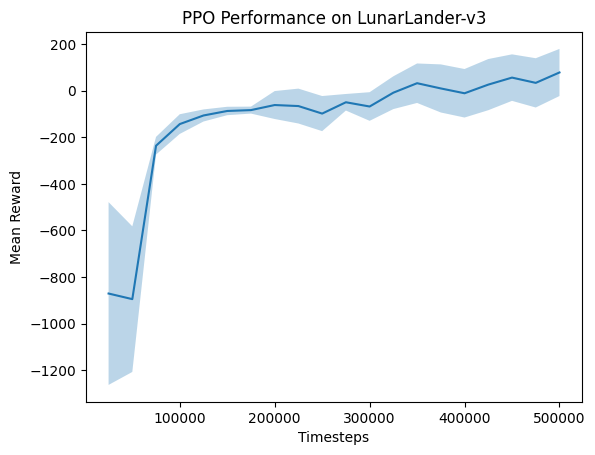

In [9]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"PPO Performance on {env_str}")
matplotlib.pyplot.show()

In [10]:
env = gymnasium.make('LunarLanderContinuous-v3')
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
env.close()

Observation Space Size:  (8,)
Action Space Size:  (2,)


In [11]:
env_str = "LunarLanderContinuous-v3"
log_dir = "./logs/{}".format(env_str)

In [12]:
#Create Training Environment)
env = make_vec_env(env_str, n_envs=1)

#Create Elevation Environment
env_val = make_vec_env(env_str, n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25_000,
                             render=False,
                             n_eval_episodes=20)

# Initialize PPO
model = PPO('MlpPolicy', env, verbose=0, ent_coef=0.005)

# Train the model
model.learn(total_timesteps=500_000,
            progress_bar=True,
            callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "ppo_lunar_lander"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Eval num_timesteps=25000, episode_reward=-150.23 +/- 75.47

Episode length: 170.35 +/- 96.21

New best mean reward!

Eval num_timesteps=50000, episode_reward=39.58 +/- 111.81

Episode length: 838.00 +/- 164.06

New best mean reward!

Eval num_timesteps=75000, episode_reward=179.17 +/- 55.76

Episode length: 615.25 +/- 63.48

New best mean reward!

Eval num_timesteps=100000, episode_reward=195.64 +/- 66.07

Episode length: 405.70 +/- 52.69

New best mean reward!

Eval num_timesteps=125000, episode_reward=227.73 +/- 22.81

Episode length: 423.15 +/- 104.48

New best mean reward!

Eval num_timesteps=150000, episode_reward=176.68 +/- 102.75

Episode length: 307.60 +/- 58.15

Eval num_timesteps=175000, episode_reward=159.41 +/- 107.83

Episode length: 290.00 +/- 38.96

Eval num_timesteps=200000, episode_reward=147.00 +/- 111.65

Episode length: 303.55 +/- 100.98

Eval num_timesteps=225000, episode_reward=143.41 +/- 117.02

Episode length: 302.25 +/- 96.87

Eval num_timesteps=250000, episode_reward=143.18 +/- 125.36

Episode length: 414.65 +/- 191.54

Eval num_timesteps=275000, episode_reward=175.41 +/- 116.02

Episode length: 311.15 +/- 78.12

Eval num_timesteps=300000, episode_reward=218.88 +/- 74.44

Episode length: 293.45 +/- 73.62

Eval num_timesteps=325000, episode_reward=205.64 +/- 89.57

Episode length: 300.85 +/- 122.76

Eval num_timesteps=350000, episode_reward=219.85 +/- 76.58

Episode length: 259.10 +/- 31.94

Eval num_timesteps=375000, episode_reward=168.38 +/- 132.60

Episode length: 278.60 +/- 54.19

Eval num_timesteps=400000, episode_reward=204.60 +/- 85.58

Episode length: 272.20 +/- 45.22

Eval num_timesteps=425000, episode_reward=159.91 +/- 116.58

Episode length: 260.10 +/- 87.68

Eval num_timesteps=450000, episode_reward=106.33 +/- 135.02

Episode length: 223.10 +/- 61.53

Eval num_timesteps=475000, episode_reward=174.35 +/- 124.42

Episode length: 237.70 +/- 70.26

Eval num_timesteps=500000, episode_reward=132.38 +/- 149.58

Episode length: 204.85 +/- 60.70

Mean reward: 88.69 +/- 141.79


In [13]:
# Create Elevation environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
env = VecVideoRecorder(env, "./videos/",
                       video_length=5000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_lunar_lander_ppo_con")

obs = env.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
      break

env.close()

Best Model - Mean reward: 155.72 +/- 102.21
Moviepy - Building video /content/videos/best_model_lunar_lander_ppo_con-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/videos/best_model_lunar_lander_ppo_con-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_lunar_lander_ppo_con-step-0-to-step-5000.mp4


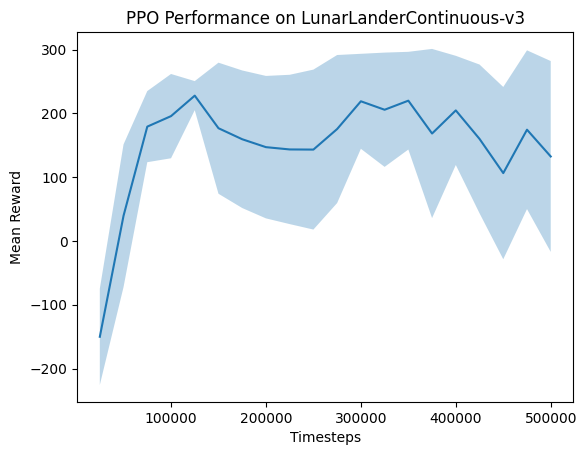

In [14]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"PPO Performance on {env_str}")
matplotlib.pyplot.show()